In [109]:
!pip install face_recognition
!pip install opencv-python-headless

In [110]:
import os
from google.colab import drive
import face_recognition
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [111]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [112]:
unlabelled_folder = '/content/drive/MyDrive/unlabelled_library_images/' #this is the folder where images originally are before labeling
labelled_folder = '/content/drive/MyDrive/labelled_library_images/' #the images are moved here
spreadsheet_folder = '/content/drive/MyDrive/library_spreadsheets/' #any database files go here

#note you can edit and put whatever folders you want those are just the name of my folders^

In [113]:
if not os.path.exists(labelled_folder):
  os.makedirs(labelled_folder)


if not os.path.exists(labelled_folder):
  os.makedirs(labelled_folder)

if not os.path.exists(spreadsheet_folder):
  os.makedirs(spreadsheet_folder)

unlabelled_images = os.listdir(unlabelled_folder)
labelled_images = os.listdir(labelled_folder)

print(unlabelled_images)

['.ipynb_checkpoints', 'rhianna.jpg', 'britney_oprah_mathew.jpg', 'ariana_michael_girlidk.webp', 'keanu_matthew.jpg']


In [114]:
if os.path.exists(spreadsheet_folder + 'faces_data.csv'):
    faces_data = pd.read_csv(spreadsheet_folder + 'faces_data.csv')[['name','face_encoding']]#data of faces and encodings
else:
    faces_data = pd.DataFrame(columns = ['name','face_encoding'])
if os.path.exists(spreadsheet_folder + 'image_face_names.csv'):
    image_face_names = pd.read_csv(spreadsheet_folder + 'image_face_names.csv') #images and the existing names in those images
else:
    image_face_names = pd.DataFrame(columns = ['image_name','face_names'])
if os.path.exists(spreadsheet_folder + 'new_data.csv'):
    new_data = pd.read_csv(spreadsheet_folder + 'new_data.csv') #this is where the new labeling data is put
else:
    new_data = pd.DataFrame(columns = ['image_name','faces'])

In [115]:
faces_data.head(11)

name                                      face_encoding
0  Ashkar  [-0.18324539065361023, 0.1227283924818039, 0.0...
1   ikram  [-0.08382032066583633, 0.08915513753890991, -0...
2  khalil  [-0.19419795274734497, 0.06705864518880844, 0....
3  isamil  [-0.14713019132614136, 0.05713728070259094, -0...
4   Ebram  [-0.07837033271789551, 0.04806605353951454, -0...
5  Suarez  [-0.20483390986919403, 0.13607002794742584, 0....
6    NEMO  [-0.05894104763865471, 0.18076062202453613, 0....
7    Wres  [-0.14568693935871124, 0.10534437000751495, 0....
8  Dwayne  [-0.14001800119876862, 0.19072787463665009, 0....
9     Tom  [-0.16988705098628998, 0.11156287044286728, 0....

In [116]:
image_face_names.head()

image_name face_names
0  WhatsApp Image 2024-05-30 at 10.18.47_97793ef2...      Ebram
1  WhatsApp Image 2024-07-17 at 18.59.31_81e74e82...      Ebram
2  321670358_1379018396174306_8323900925920846555...      Ebram
3                                            tom.jpg        Tom
4                                         dwayne.jpg     Dwayne

In [117]:
new_data.head()

image_name  \
0  ariana_michael_girlidk.webp   
1     britney_oprah_mathew.jpg   
2        keanu_matthew.jpg.jpg   
3                  rhianna.jpg   

                                             faces  
0  [Ariana Grande, Michael B Jordan, Actress Girl]  
1  [Brittney Spears, Oprah Wimfrey, Matthew Perry]  
2                    [Keanu Reeves, Matthew Perry]  
3                                        [Rhianna]

newdata structure:
image_name, faces (from left to right)

Pseudocode for later (initial labeling):
```
for all_images:
  run face_recognition();
  for all_faces:
    if !smallest.face.distance == csv_face_name:
       add_encoding_to_faces_data();
    if new_face:
       add_row_to_faces_data();
    add_row_to_image_face_names(); //needs to follow face_encodings placement not the new_csv files placement
```

Cascade code

```
for all_images:
  run face_recognition();
  for all_faces:
    if face.passes_threshold:
       add_encoding_to_faces_data(face.get_smallest_distance());
    else:
       label_as_unkown(); #might just be do nothing in this case
    add_row_to_image_face_names();
```


print images code

```
for all_images:
  run face_recognition();
  for all_faces:
    if face.passes_threshold:
       label_face(face.get_smallest_distance());
    else:
       label_as_unkown(); #might just be do nothing in this case
    print_using_opencv();
```




In [118]:
faces_data['face_encoding'] = faces_data['face_encoding'].apply(lambda enc: np.array(eval(enc)))
new_data['faces'] = new_data['faces'].apply(lambda x: eval(x.replace('[', '["').replace(']', '"]').replace(',', '","')))



In [119]:
def find_closest_encoding(df, encoding):
  all_encodings = np.array(df['face_encoding'].tolist())
  distances = face_recognition.face_distance(all_encodings, encoding)
  best_match_index = np.argmin(distances)
  if distances[best_match_index] <= 0.55:
    matched_name = df.iloc[best_match_index]['name']
  else:
    matched_name = 'UNKOWNINSTANCE'
  return best_match_index, matched_name

In [128]:
def label_using_csv():
  unlabelled_images = os.listdir(unlabelled_folder)
  for image in unlabelled_images:
    try:
      image_dir = unlabelled_folder+image
      pairs = {}
      faces_unparsed = new_data.loc[new_data['image_name'] == image, 'faces'].iloc[0]
      try:
        faces_in_curr = eval(faces_unparsed.replace('[', '["').replace(']', '"]').replace(',', '","'))
      except:
        faces_in_curr = faces_unparsed
      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)
      face_encodings_sorted = [encoding for _, encoding in sorted(zip(face_locations, face_encodings), key=lambda x: x[0][3])]

      for i,face_encoding in enumerate(face_encodings_sorted):
        if len(faces_data[faces_data['name'] == faces_in_curr[i]]) > 0:
          row_ind, name = find_closest_encoding(faces_data,face_encoding)
          if not name == faces_in_curr[i]:
            faces_data.loc[len(faces_data)] = [faces_in_curr[i], face_encoding.tolist()]
        else:
          faces_data.loc[len(faces_data)] = [faces_in_curr[i], face_encoding.tolist()]
        pairs[str(face_encoding.tolist())] = faces_in_curr[i]

      names_corrected = []

      for face_encoding in face_encodings:
        names_corrected.append(pairs[str(face_encoding.tolist())])

      image_face_names.loc[len(image_face_names)] = [image,names_corrected]

      Path(unlabelled_folder + image).rename(labelled_folder + image)



    except Exception as e: #using this to catch non-images
      print(e)





In [121]:
def cascade_on_uploaded_images():
  unlabelled_images = os.listdir(unlabelled_folder)
  for image in unlabelled_images:
    try:
      image_dir = unlabelled_folder+image

      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)
      names_corrected = []
      for i,face_encoding in enumerate(face_encodings):
        row_ind, name = find_closest_encoding(faces_data,face_encoding)
        if name != 'UNKOWNINSTANCE':
          names_corrected.append(name)
        else:
          #label as unkown when thats implemented in the normal version
          pass
      image_face_names.loc[len(image_face_names)] = [image,names_corrected]
      Path(unlabelled_folder + image).rename(labelled_folder + image)

    except Exception as e: #using this to catch non-images
      print(e)

In [122]:
def draw_labels_on_image(image, face_locations, names):
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for (top, right, bottom, left), name in zip(face_locations, names):
        cv2.rectangle(image_bgr, (left, top), (right, bottom), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_bgr, name, (left, bottom + 20), font, 0.5, (0, 255, 0), 2)
    return image_bgr

In [140]:
def print_labelled_images():
  labelled_images = os.listdir(labelled_folder)
  for image in labelled_images:
    try:
      image_dir = labelled_folder+image

      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)
      names = []
      for i,face_encoding in enumerate(face_encodings):
        row_ind, name = find_closest_encoding(faces_data,face_encoding)
        names.append(name)
      image_with_labels = draw_labels_on_image(loaded_image, face_locations, names)
      cv2_imshow(image_with_labels)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
    except Exception as e: #using this to catch non-images
      print(e)

In [141]:
def save_to_csv():
  faces_data.to_csv(spreadsheet_folder + 'faces_data.csv', index=False)
  image_face_names.to_csv(spreadsheet_folder + 'image_face_names.csv', index=False)

In [143]:
choice = input("Would you like to cascade on images or use labeling input ('c'/'l'): ")
if choice.lower() == 'l':
  label_using_csv()
else:
  cascade_on_uploaded_images()
save_to_csv()

Would you like to cascade on images or use labeling input ('c'/'l'): l
single positional indexer is out-of-bounds


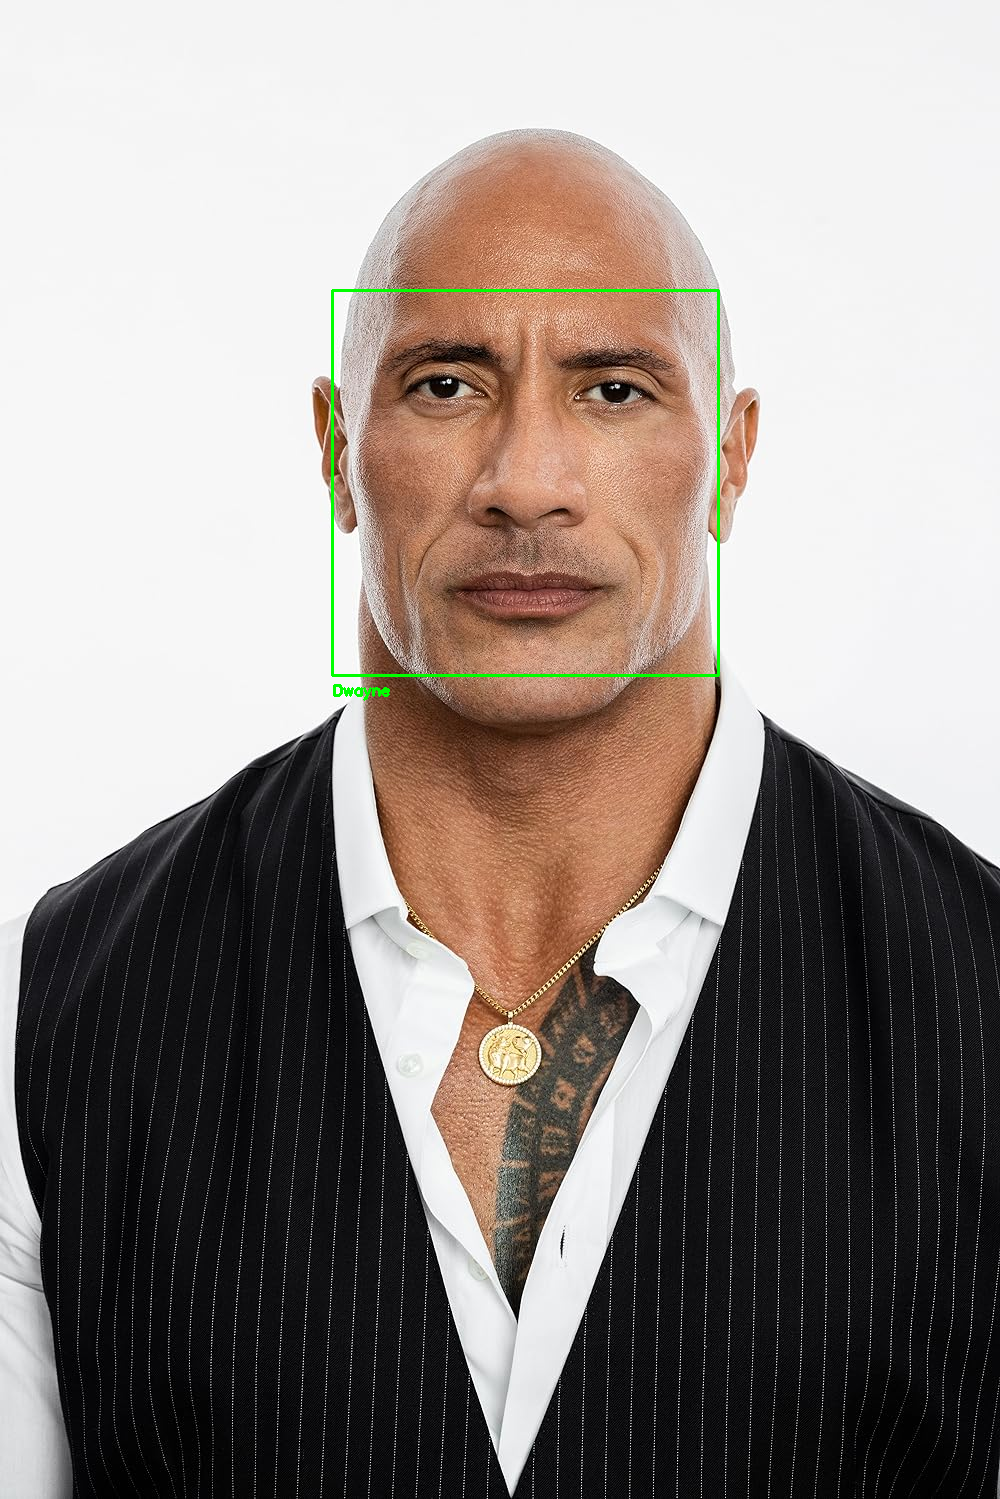

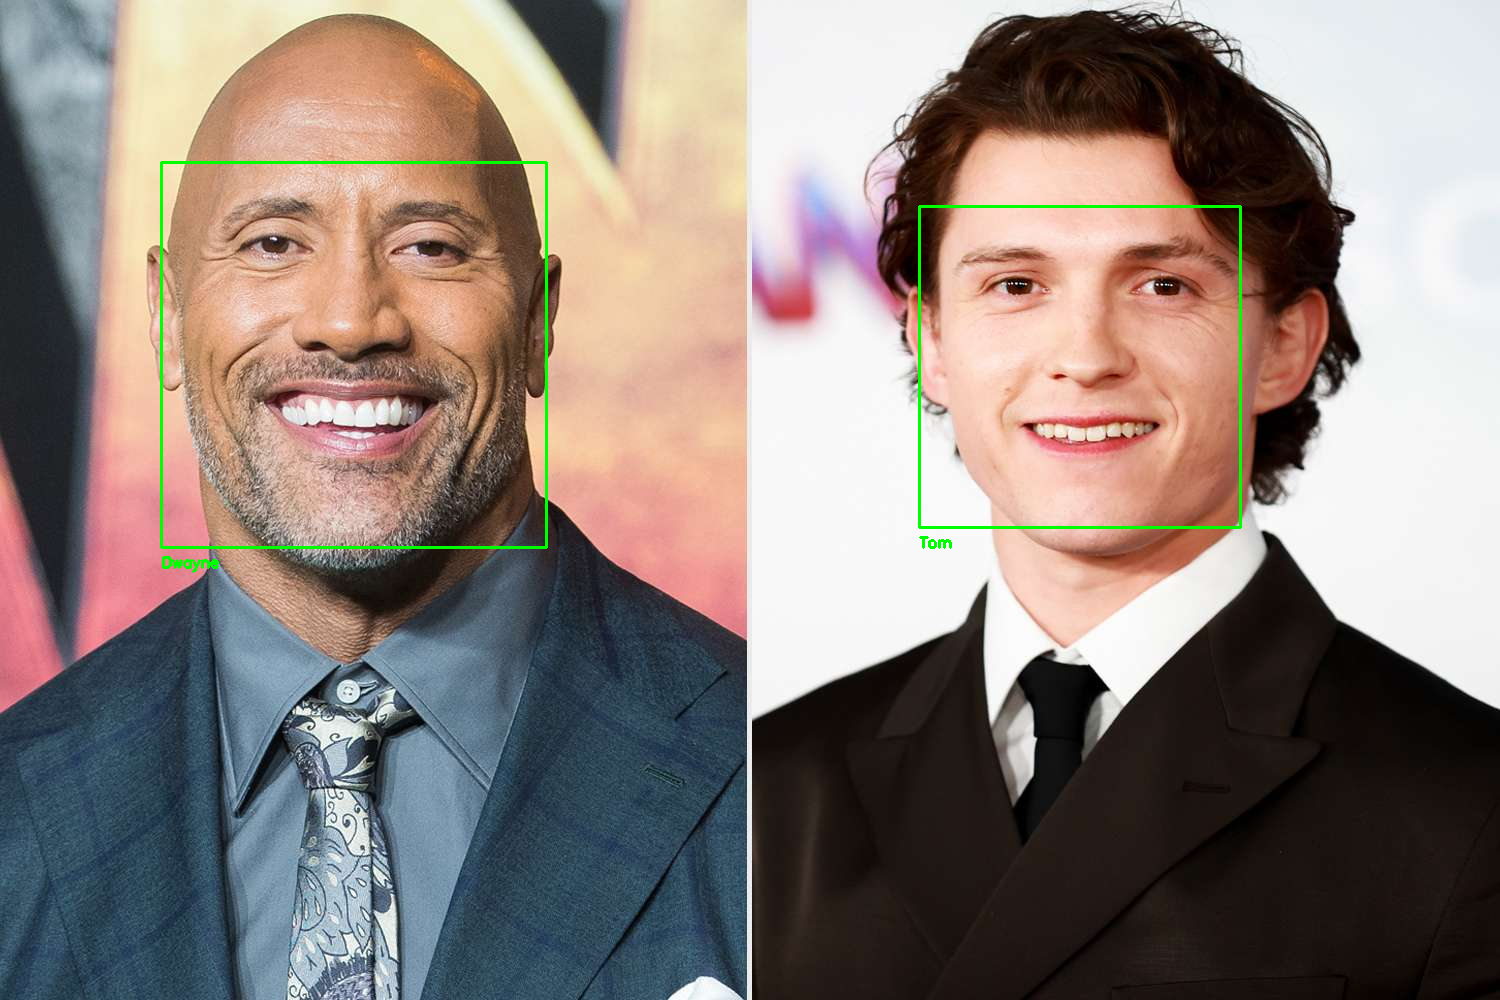

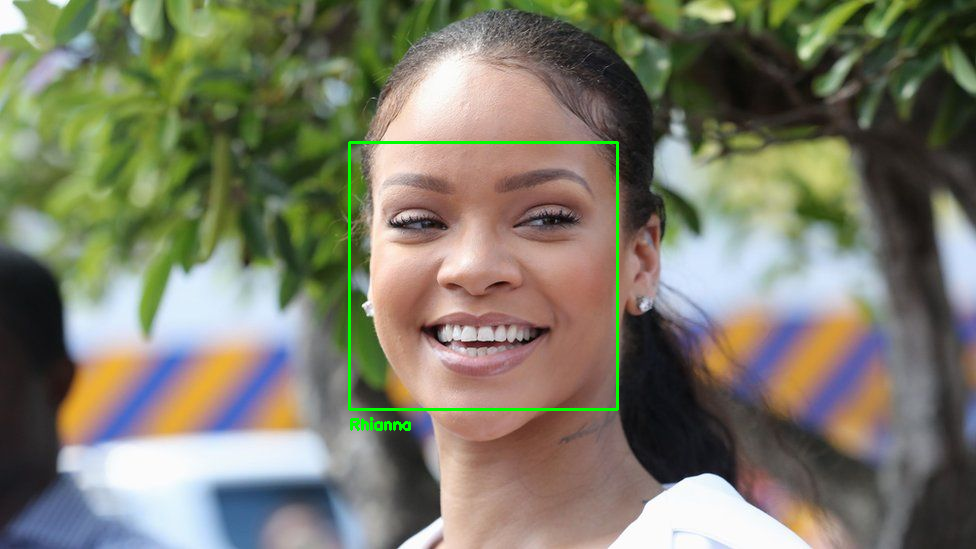

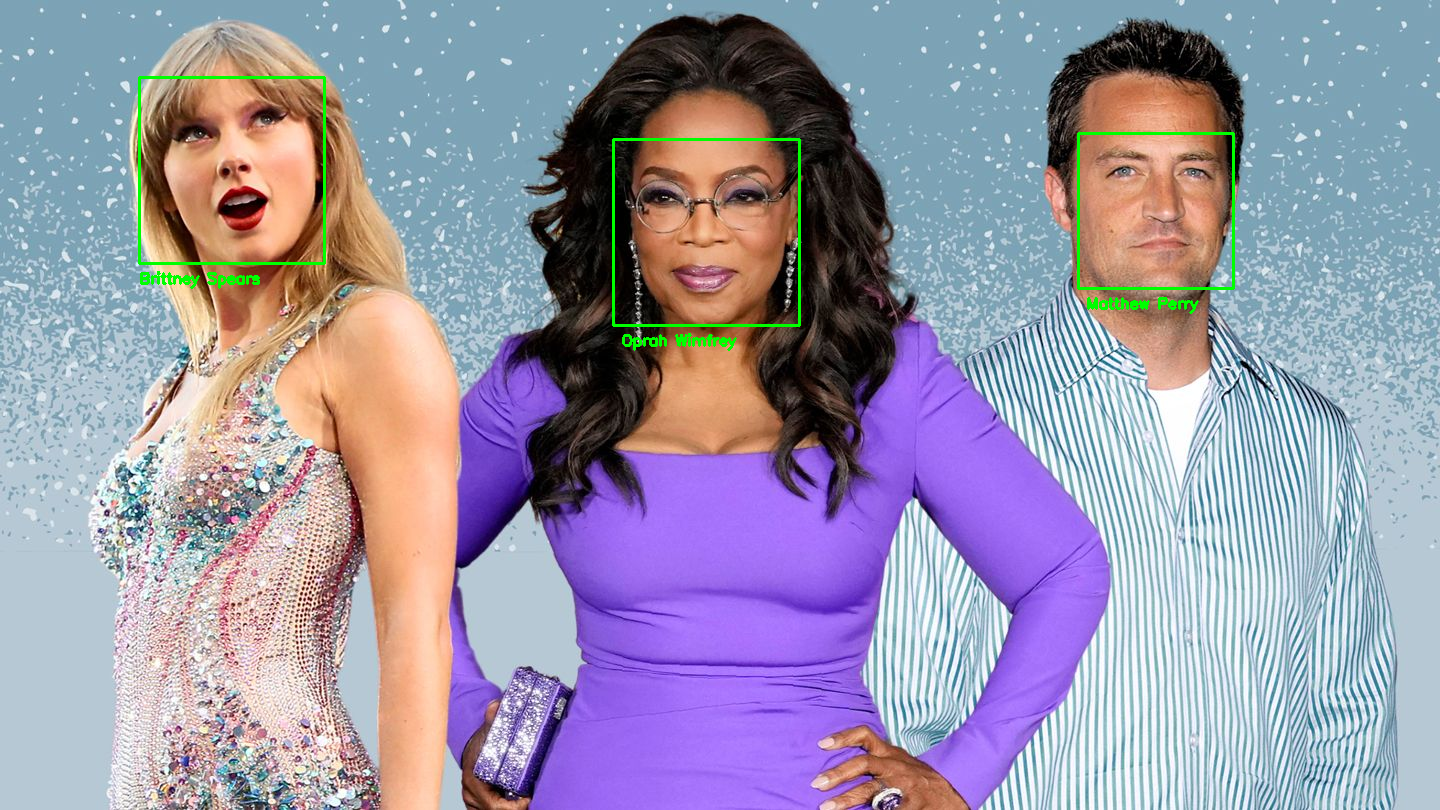

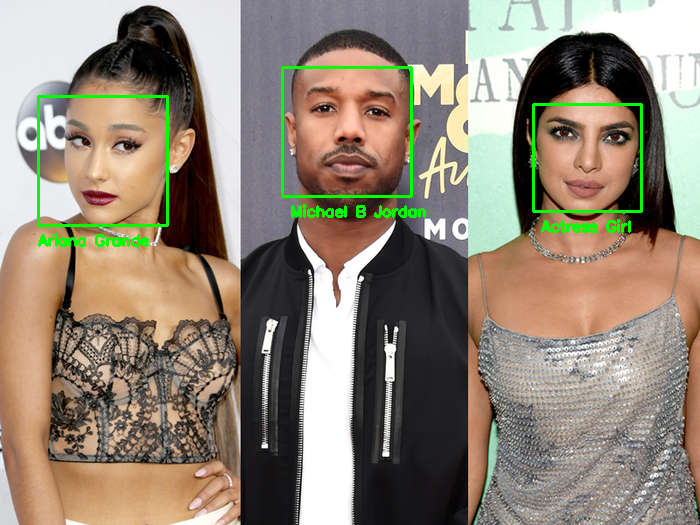

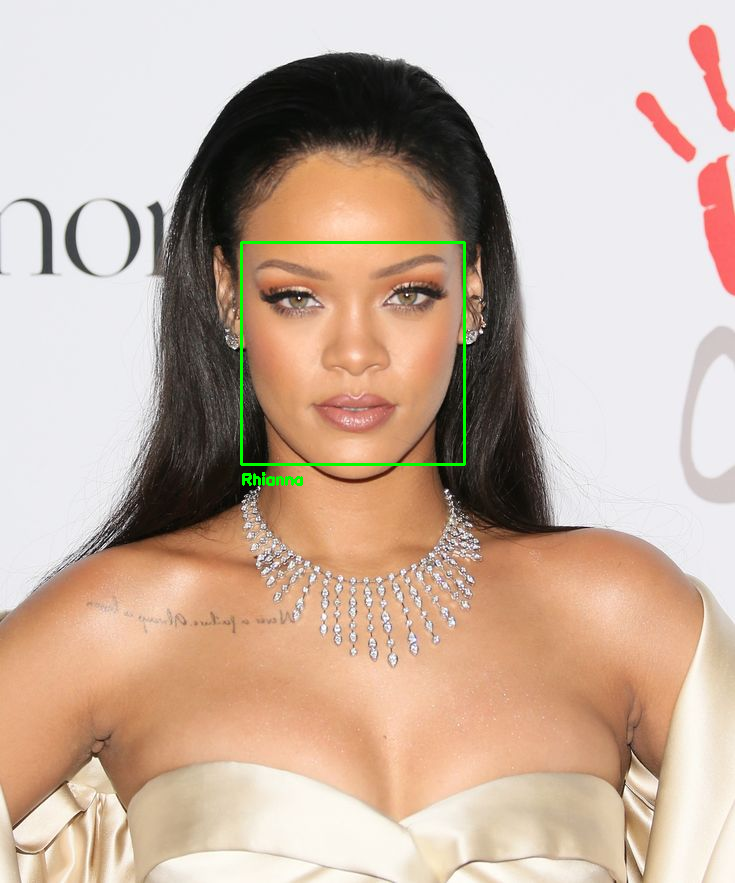

In [139]:
print_labelled_images()


In [130]:
cascade_on_uploaded_images()

[Errno 21] Is a directory: '/content/drive/MyDrive/unlabelled_library_images/.ipynb_checkpoints'


In [ ]:
#ask user to cascade or use upload csv

